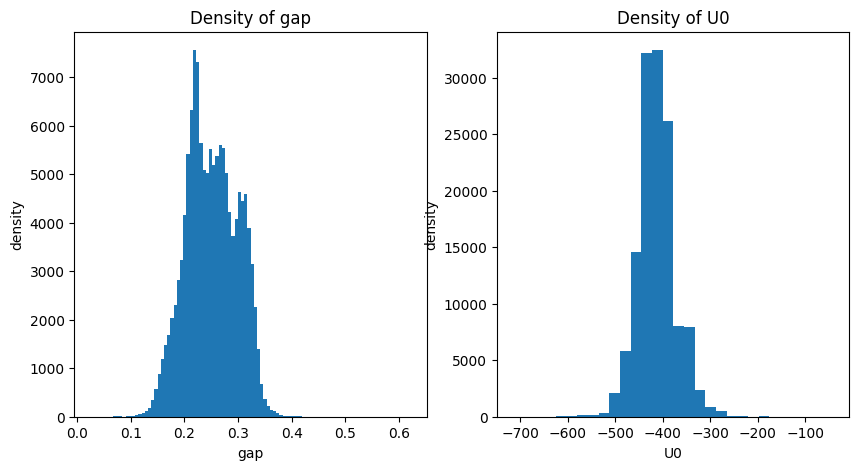

In [4]:
# read qm9.csv and extract gap U0 column

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df1 = pd.read_csv('data/qm9.csv', usecols=['gap'])
df2 = pd.read_csv('data/qm9.csv', usecols=['U0'])

# plot density of U0 and gap in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(df1['gap'], bins=100)
ax[0].set_xlabel('gap')
ax[0].set_ylabel('density')
ax[0].set_title('Density of gap')
ax[1].hist(df2['U0'], bins=30)
ax[1].set_xlabel('U0')
ax[1].set_ylabel('density')
ax[1].set_title('Density of U0')
plt.show()

## Cleaning the Cell Complex Data

In [6]:
import pickle 

with open('data/qm9_train_cell_complex.pkl', 'rb') as f:
    data = pickle.load(f)

## Geting Rank-2 cells (rings) for molecules 

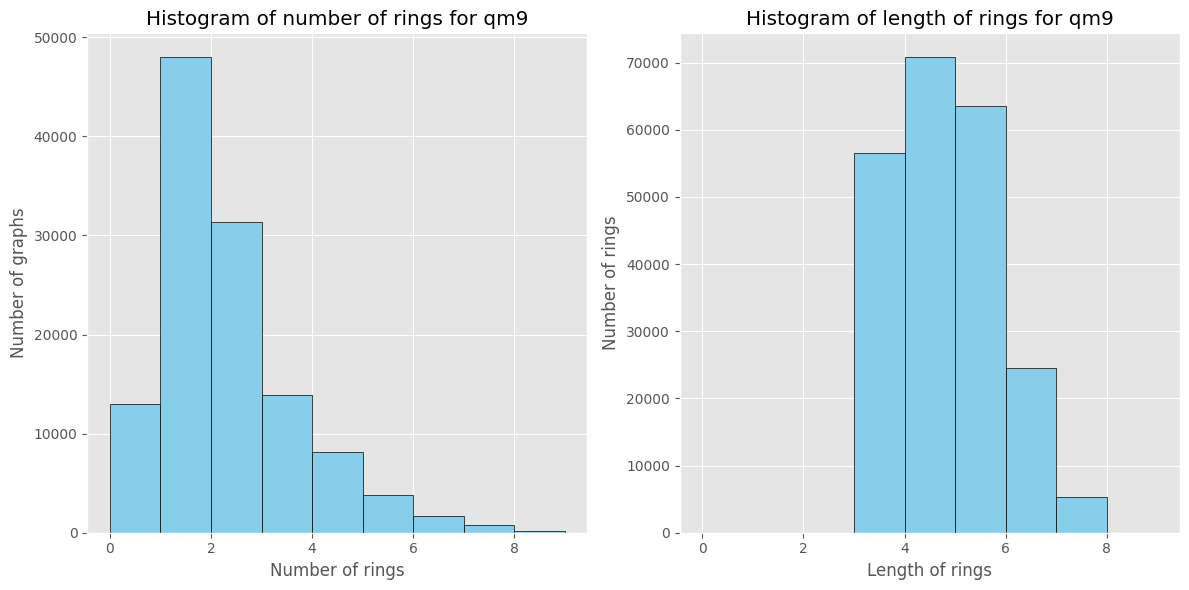

In [7]:
with open('data/qm9_train_rings.pkl', 'rb') as f:
    qm9_rings = pickle.load(f)

qm9_rings_count = []
qm9_rings_len = []

for i in range(len(qm9_rings)):
    qm9_rings_count.append(len(qm9_rings[i]))
    for j in range(len(qm9_rings[i])):
        qm9_rings_len.append(len(qm9_rings[i][j]))

# plot histogram
import matplotlib.pyplot as plt
import numpy as np

# Use a style for the plot
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first histogram with a color and edge color
axs[0].hist(qm9_rings_count, bins=np.arange(0, 10, 1), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Number of rings')
axs[0].set_ylabel('Number of graphs')
axs[0].set_title('Histogram of number of rings for qm9')

# Plot the second histogram with a color and edge color
axs[1].hist(qm9_rings_len, bins=np.arange(0, 10, 1), color='skyblue', edgecolor='black')
axs[1].set_xlabel('Length of rings')
axs[1].set_ylabel('Number of rings')
axs[1].set_title('Histogram of length of rings for qm9')

plt.tight_layout()
plt.show()


In [8]:
# calculate the average number of edges
import numpy as np

with open('data/qm9_train_cell_complex.pkl', 'rb') as f:
    qm9_train_cc = pickle.load(f)

In [9]:
qm9_train_cc[0].number_of_edges()

2

18.80314569536424


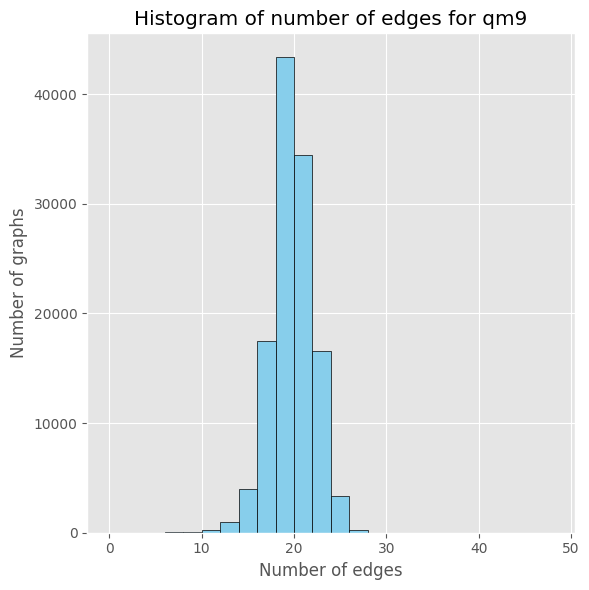

In [13]:
edges = []
for i in range(len(qm9_train_cc)):
    edges.append(qm9_train_cc[i].number_of_edges())
    
print(np.mean(edges))
# plot histogram
import matplotlib.pyplot as plt
import numpy as np

# Use a style for the plot
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
# Plot the first histogram with a color and edge color
axs.hist(edges, bins=np.arange(0, 50, 2), color='skyblue', edgecolor='black')
axs.set_xlabel('Number of edges')
axs.set_ylabel('Number of graphs')
axs.set_title('Histogram of number of edges for qm9')

plt.tight_layout()
plt.show()

## Create Cell Complexes with TopoModelX

We can choose following attributes for nodes: 
1. label: type of atom 
2. atomic_num
3. formal charge 
4. chiral_tag 
5. hybridization
6. num_explicit_hs 
7. is_aromatic 


In [7]:
from toponetx.classes.cell_complex import CellComplex

cell_complex = CellComplex(mol, {'gap' : 0.1, 'U0': 23})
cell_complex.nodes(data=True)
print(cell_complex.get_node_attributes('label'))
print(cell_complex.get_node_attributes('atomic_num'))

{0: 'C', 1: 'C', 2: 'C', 3: 'O', 4: 'O', 5: 'C', 6: 'C', 7: 'O', 8: 'C'}
{0: 6, 1: 6, 2: 6, 3: 8, 4: 8, 5: 6, 6: 6, 7: 8, 8: 6}


In [205]:
cell_complex.name

{'gap': 0.1, 'U0': 23}

In [151]:
# if we only consider label for now 
from utils.data_loader_mol import extract_node_feature_matrix_qm9

node_feature_matrix = extract_node_feature_matrix_qm9(cell_complex)
print(node_feature_matrix)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])


The label of edge determines single, double, and triple bonds.

In [152]:
from utils.data_loader_mol import extract_edge_features_qm9
print(cell_complex.get_edge_attributes('label'))

# extract edge features
edge_features = extract_edge_features_qm9(cell_complex)
print(edge_features)

{(0, 1): 1, (1, 2): 1, (1, 8): 1, (2, 3): 1, (2, 8): 1, (3, 4): 2, (4, 5): 1, (4, 6): 1, (6, 7): 2, (6, 8): 1}
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])


# derive upper and lower laplacian matrix for edges

In [161]:
cell_complex.add_cells_from(mol_rings, rank=2)
print(cell_complex.shape)
print(cell_complex.edges(data=True))
print(cell_complex.down_laplacian_matrix(rank=1, signed = False).todense())
print(cell_complex.up_laplacian_matrix(rank=1, signed = False).todense())

(9, 11, 2)
[(0, 1, {'label': 1}), (0, 4, {}), (1, 2, {'label': 1}), (1, 8, {'label': 1}), (2, 3, {'label': 1}), (2, 8, {'label': 1}), (3, 4, {'label': 2}), (4, 5, {'label': 1}), (4, 6, {'label': 1}), (6, 7, {'label': 2}), (6, 8, {'label': 1})]
[[2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [1. 0. 2. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 2. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 2. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 2. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 2. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 2. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 2. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 1.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 2.]]
[[2. 2. 2. 0. 2. 0. 2. 0. 0. 0. 0.]
 [2. 2. 2. 0. 2. 0. 2. 0. 0. 0. 0.]
 [2. 2. 2. 0. 2. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 2. 0. 2. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 2. 0. 2. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [170]:
G = nx.Graph()
G.graph['my_attribute'] = 0.898

# Access the attribute
print(G.graph['my_attribute'])


0.898


In [16]:
with open('data/qm9_train_cell_complex.pkl', 'rb') as f:
    qm9_train_cell_complex = pickle.load(f)

In [17]:
max([len(cell_complex.edges) for cell_complex in qm9_train_cell_complex])

13

In [13]:
max([len(cell_complex.nodes) for cell_complex in qm9_train_cell_complex])

9

In [30]:
import torch
cc = qm9_train_cell_complex[180]
torch.from_numpy(cc.up_laplacian_matrix(rank=1, signed = False).todense()).float()

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.]])

In [14]:
import torch

# Example edge feature matrix: 5 edges, 4 features per edge
edge_features = torch.tensor([
    [1, 2, 3, 4],
    [4, 3, 2, 1],
    [1, 3, 1, 3],
    [2, 2, 2, 2],
    [5, 1, 3, 4]
])

# Max pooling across edges
max_pooled_features = torch.max(edge_features, 0)[0]

print(max_pooled_features)


tensor([5, 3, 3, 4])


In [8]:
def group_indices(lst):
    # Dictionary to hold indices for each unique value
    indices = {}
    for i, val in enumerate(lst):
        if val not in indices:
            indices[val] = []
        indices[val].append(i)

    # Convert the dictionary values to a list of lists
    grouped_indices = list(indices.values())
    return grouped_indices

# Example usage
integer_list = [0, 0, 0, 1, 1, 1, 2, 2, 3]
grouped_indices = group_indices(integer_list)
print(grouped_indices)


[[0, 1, 2], [3, 4, 5], [6, 7], [8]]


In [16]:
tensor = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
a = [[0, 2]]

# Flatten the list of lists

# Index the first and third rows
selected_rows = tensor[a]

print(selected_rows) 

tensor([[1, 2, 3],
        [7, 8, 9]])
